# Analyzing how different NY birds are represented in the literature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from adjustText import adjust_text

In [2]:
input_file_name = 'liam_birds_literature_data.csv'

In [3]:
# Read data

df = pd.read_csv(input_file_name)
df.head(5)

,keyword,Unnamed: 1,no keyword,Bicknell's Thrush,Cooper's Hawk,King Rail,Short-eared Owl,Common Nighthawk,Mute Swan,Loggerhead Shrike,Snowy Owl,Horned Lark,Double-crested Cormorant,American Kestrel,Osprey,Blue Jay,Bald Eagle,Ruby-throated Hummingbird,Wild Turkey
0,NaN,search term,NaN,Catharus bicknelli,Accipiter cooperii,Rallus elegans,Asio flammeus,Chordeiles minor,Cygnus olor,Lanius ludovicianus,Bubo scandiacus,Eremophila alpestris,Phalacrocorax auritus,Falco sparverius,Pandion haliaetus,Cyanocitta cristata,Haliaeetus leucocephalus,Archilochus colubris,Meleagris gallopavo
1,no keyword,NaN,NaN,120,242,97,210,141,177,202,41,167,456,472,422,540,614,172,620
2,black bear,Ursus americanus,929.0,8,40,8,25,21,10,22,6,29,12,38,47,40,82,17,123
3,bobcat,Lynx rufus,480.0,6,44,7,21,14,13,16,3,27,21,41,41,26,61,15,70
4,chipmunk,Tamias striatus,746.0,4,43,7,15,10,8,15,6,12,11,41,25,73,43,20,77


All data is stored as one table, but in spirit, there are several tables here:
1. Birds we study (columns), with their Latin names (given in row #2, using 1-index notation)
2. "Foundation species" (first several rows) with their latin names (2nd column, rows 4:45)
3. Total number of papers for each bird species (row #3)
4. Total number of papers for each foundation species (column #3)
5. Co-occurrence of birds and foundational species (columns 4:end and rows 4:45)
6. Abract search terms, searched alone (data in column 3, rows 46:end)
7. Co-occurrence of birds and abstract terms (columns 4:end, rows 46:end)

Let's break this big dataframe above accordingly (while also moving from 1-indexed to 0-index system).

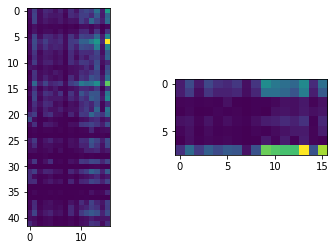

In [4]:
df_birds = df.iloc[:1, 3:].transpose().reset_index()
df_birds.columns = ['name', 'latin']

df_species = df.iloc[2:44, :2]
df_species.columns = ['name', 'latin']

df_terms = df.iloc[44:, :1]

df_counts1 = df.set_index('keyword').iloc[2:44, 2:]
counts1 = df_counts1.values.astype(float)  # to numpy
plt.subplot(121)
plt.imshow(counts1);

df_counts2 = df.set_index('keyword').iloc[44:, 2:]
counts2 = df_counts2.values.astype(float)  # to numpy
plt.subplot(122)
plt.imshow(counts2);

birds_alone = df.iloc[1, 3:].values.astype(float)
species_alone = df.iloc[2:44, 2].values.astype(float)
terms_alone = df.iloc[44:, 2].values.astype(float)

It's time now to normalize by probabilities of meeting each term independently. Also, to go from counts to probabilities we are supposed to use an estimation of the total number of "ecological papers that mention NY". Possible estimations:

* "New York State" "species" = 307000
* "New York State" "habitat" = 66400
* "New York State" "environmental" = 1110000
* "New York State" "forest" = 162000
* "New York State" "ecological" = 137000
* "New York State" "ecology" = 158000

The good news though that that ultimately nothing depends on this value. Look, say there are N papers about the ecology of New York. Then we have 2 terms, with two counts of papers about these terms n1 and n2, and a joint count n12. In theory we are supposed to go to probabilities p1=n1/N, p2=n2/N, and p12=n12/N, and then compare how much p12 probability differs from an expected probability of p1∙p2 that we would expect if terms were independent. So k = p12/(p1∙p2) = N∙n12/(n1∙n2). Which means that ultimately if we make a mistake in N, just all estimations k get scaled by N. And so, the actual value of N doesn't matter, as we only care about relative values of k, not about their absolute values.

So let's just ignore N, and go ahead with dividing n12 by n1 and n2, and call it a day.

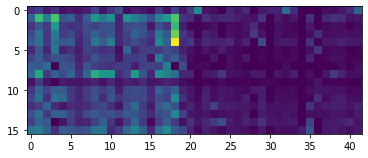

In [5]:
# Normalizing

p1 = (counts1/birds_alone)/species_alone[:,np.newaxis]
plt.imshow(p1.T);

# Interaction with plants is much weaker, which is kinda expected

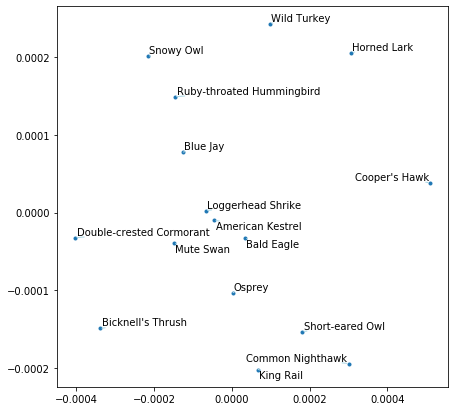

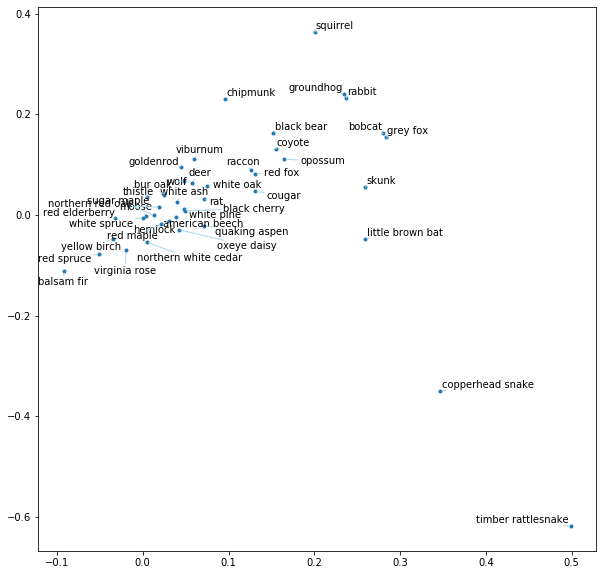

In [6]:
# Let's try to classify birds based on their associations
# (honestly, not a very successful attempt)

def draw_labels(xy, texts, adjust=False):
    texts = [plt.text(xy[i,0], xy[i,1], val) for i,val in enumerate(texts)]
    if adjust:
        # Next line may be slow if you have lots of points:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='lightblue'))
        # Read here if it doesn't work at all: https://github.com/Phlya/adjustText

pca = decomposition.PCA(n_components=2)
pca.fit(p1.T)
scores = pca.transform(p1.T)

plt.figure(figsize=(7, 7))
plt.plot(scores[:,0], scores[:,1], '.');
draw_labels(scores, df_birds.name, adjust=True)
    
plt.figure(figsize=(10,10))
loadings = pca.inverse_transform(np.array(np.eye(2))).T
plt.plot(loadings[:,0], loadings[:,1], '.');
draw_labels(loadings, df_species.name, adjust=True);

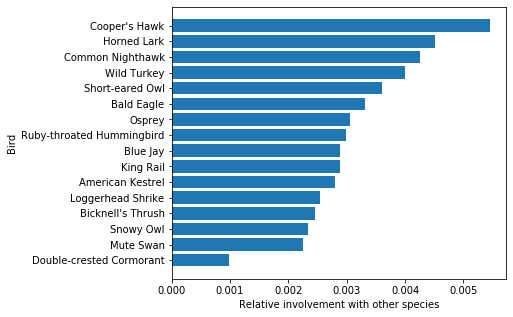

In [7]:
# Sort birds by the level of their involvement with all species

rating = np.sum(p1.T, axis=1)
ind = np.argsort(rating)
plt.figure(figsize=(6,5))
plt.barh(df_birds.name[ind], rating[ind]);
plt.xlabel('Relative involvement with other species');
plt.ylabel('Bird');

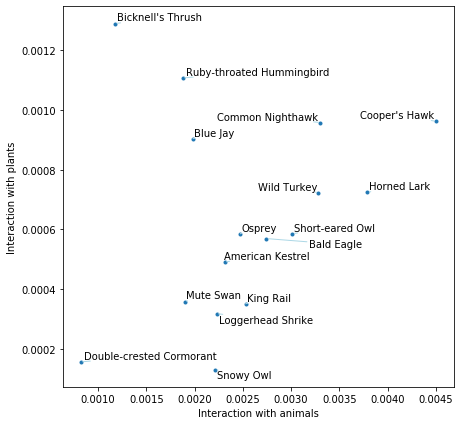

In [8]:
# Let's manually classify them as "tree-friends" vs "animal-friends"

ind_first_tree = 20
rating1 = np.sum(p1[:ind_first_tree, :].T, axis=1)
rating2 = np.sum(p1[ind_first_tree:, :].T, axis=1)

plt.figure(figsize=(7,7))
ax = plt.axes()
plt.plot(rating1, rating2, '.');
texts = draw_labels(np.stack((rating1, rating2), axis=1), df_birds.name.values, adjust=True)
plt.xlabel('Interaction with animals');
plt.ylabel('Interaction with plants');
# ax.set_aspect('equal')  # If you want to be reminded that interactions with lants are 3-4 times weaker

# Part 2, terms

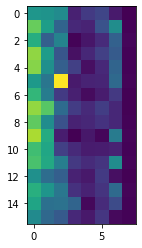

In [9]:
# Normalize

p2 = ((counts2/birds_alone)/terms_alone[:,np.newaxis]).T
# Now birds are rows, and measurements are columns
plt.imshow(p2);

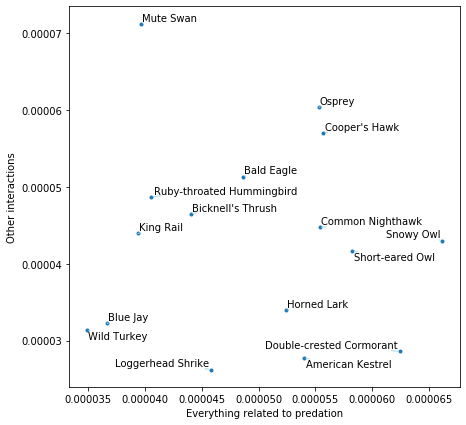

In [13]:
# Example: predation vs everything else

score1 = np.sum(p2[:, :2], axis=1)
score2 = np.sum(p2[:, 2:], axis=1)
plt.figure(figsize=(7, 7))
plt.plot(score1, score2, '.');
draw_labels(np.stack((score1, score2), axis=1), df_birds.name.values, adjust=True)
plt.xlabel('Everything related to predation');
plt.ylabel('Other interactions');